In [1]:
#https://drive.google.com/file/d/18LvYri6DxzxErx29B1HTx1UCzMfNwCWT/view?usp=sharing
!gdown --id 18LvYri6DxzxErx29B1HTx1UCzMfNwCWT  # Downloading the data from google drive 

Downloading...
From: https://drive.google.com/uc?id=18LvYri6DxzxErx29B1HTx1UCzMfNwCWT
To: /content/train.tar.gz
1.47GB [00:13, 106MB/s] 


In [1]:
import tensorflow as tf

import cv2
import numpy as np

from tensorflow.keras import Model
from tensorflow.keras.layers import (Add, Concatenate, Conv2D, Input,Lambda,
LeakyReLU, MaxPool2D, UpSampling2D, ZeroPadding2D,BatchNormalization)

import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
	binary_crossentropy,
	sparse_categorical_crossentropy
)


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
def predict(PATH):
  def Darknet_Conv(x, filters, size, strides=1, batch_norm=True):
    ''' Convolution block for darknet architecture '''
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x
  
  def Darknet_Residual(x, filters):
    '''residual block for darknet architecture '''
    prev = x
    x = Darknet_Conv(x, filters // 2, 1)
    x = Darknet_Conv(x, filters, 3)
    x = Add()([prev, x])
    return x



  def Darknet_Block(x, filters, blocks):
    ''' Darknet Block consisting of convolution and residual layers'''
    x = Darknet_Conv(x, filters, 3, strides=2)
    for _ in range(blocks):
        x = Darknet_Residual(x, filters)
    return x


  def Darknet(name=None):
    ''' Darknet architecture '''
    x = inputs = Input([None, None, 3])
    x = Darknet_Conv(x, 32, 3)
    x = Darknet_Block(x, 64, 1)
    x = Darknet_Block(x, 128, 2)  # skip connection
    x = x_36 = Darknet_Block(x, 256, 8)  # skip connection
    x = x_61 = Darknet_Block(x, 512, 8)
    x = Darknet_Block(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)
  
  def Yolo_Conv(filters, name=None):
    ''' convolution block for yolo architecture to detect objects '''
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = Darknet_Conv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = Darknet_Conv(x, filters, 1)
        x = Darknet_Conv(x, filters * 2, 3)
        x = Darknet_Conv(x, filters, 1)
        x = Darknet_Conv(x, filters * 2, 3)
        x = Darknet_Conv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

  def Yolo_Output(filters, anchors, classes, name=None):
    ''' Function to output predictions of object '''
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = Darknet_Conv(x, filters * 2, 3)
        x = Darknet_Conv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                            anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output
  
  yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                         (59, 119), (116, 90), (156, 198), (373, 326)],
                        np.float32) / 416
  yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])
  def yolo_boxes(pred, anchors, classes):
    ''' Function to get absolute coordinates of bounding boxes and objectness and class probs'''
    # pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))
    Grd_Siz = tf.shape(pred)[1:3]
    Box_xy, Box_wh, Objectness, Class_Prob = tf.split(
        pred, (2, 2, 1, classes), axis=-1)
    #print(class_probs)
    Box_xy = tf.sigmoid(Box_xy)
    Objectness = tf.sigmoid(Objectness)
    Class_Prob = tf.sigmoid(Class_Prob)
    Pred_box = tf.concat((Box_xy, Box_wh), axis=-1)  

    
    Grid = tf.meshgrid(tf.range(Grd_Siz[1]), tf.range(Grd_Siz[0]))
    Grid = tf.expand_dims(tf.stack(Grid, axis=-1), axis=2)  

    Box_xy = (Box_xy + tf.cast(Grid, tf.float32)) / \
        tf.cast(Grd_Siz, tf.float32)
    Box_wh = tf.exp(Box_wh) * anchors

    Box_x1y1 = Box_xy - Box_wh / 2
    Box_x2y2 = Box_xy + Box_wh / 2
    Bbox = tf.concat([Box_x1y1, Box_x2y2], axis=-1)

    return Bbox, Objectness, Class_Prob, Pred_box

  def Yolo_V3(size=None, channels=3, anchors=yolo_anchors,masks=yolo_anchor_masks, classes=80, training=False,confidence_threshold=0.4,iou_threshold=0.4):
	  x = inputs = Input([size, size, channels], name='input')

	  x_36, x_61, x = Darknet(name='yolo_darknet')(x)

	  x = Yolo_Conv(512, name='yolo_conv_0')(x)
	  output_0 = Yolo_Output(512, len(masks[0]), classes, name='yolo_output_0')(x)

	  x = Yolo_Conv(256, name='yolo_conv_1')((x, x_61))
	  output_1 = Yolo_Output(256, len(masks[1]), classes, name='yolo_output_1')(x)

	  x = Yolo_Conv(128, name='yolo_conv_2')((x, x_36))
	  output_2 = Yolo_Output(128, len(masks[2]), classes, name='yolo_output_2')(x)

	  if training:
		  return Model(inputs, (output_0, output_1, output_2), name='yolov3')

	  boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
					  name='yolo_boxes_0')(output_0)
	  boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
					  name='yolo_boxes_1')(output_1)
	  boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
					  name='yolo_boxes_2')(output_2)

	  outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes,confidence_threshold,iou_threshold),
					  name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

	  return Model(inputs, outputs, name='yolov3')
 
  def yolo_nms(outputs, anchors, masks, classes, confidence_threshold=0.4,iou_threshold=0.4):
    ''' Function to prune number of bounding boxes to one with max iou score  '''
    
    b = []
    c=[]
    t=[]

    for obj in outputs:
        b.append(tf.reshape(obj[0], (tf.shape(obj[0])[0], -1, tf.shape(obj[0])[-1])))
        c.append(tf.reshape(obj[1], (tf.shape(obj[1])[0], -1, tf.shape(obj[1])[-1])))
        t.append(tf.reshape(obj[2], (tf.shape(obj[2])[0], -1, tf.shape(obj[2])[-1])))

    Bbox = tf.concat(b, axis=1)
    Confidence = tf.concat(c, axis=1)
    Class_probs = tf.concat(t, axis=1)

    scores = Confidence * Class_probs
    boxes, scores, Classes, Valid_Detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(Bbox, (tf.shape(Bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=100,
        max_total_size=100,
        iou_threshold=0.4,
        score_threshold=0.4)

    return boxes, scores, Classes, Valid_Detections
  def draw_images(image_path,xml_path):
    ''' drawing bounding boxes in a image from xml files for visualizing ground truth '''
    damage_types = ['D00','D10','D20','D40'] #considering only 4 categories of damage types for this problem
    image = cv2.imread(image_path)
  #path = image_path.split('/')[-1].split('.')[0] # getting .xml file name from path
  
    xmlfile = open(xml_path)
    tree = ElementTree.parse(xmlfile)
    root = tree.getroot()
  
    for obj in root.iter('object'):
      class_name = obj.find('name').text
      if class_name not in damage_types:
        continue
      box = obj.find('bndbox')
      xmin = int(box.find('xmin').text)
      xmax = int(box.find('xmax').text)
      ymin = int(box.find('ymin').text)
      ymax = int(box.find('ymax').text)
      if class_name == 'D00':
        color = (0,255,0)
      elif class_name == 'D10': 
        color = (255,0,0)
      elif class_name == 'D20':
        color =  (255,255,0)
      else:
        color = (0,255,255)
      
      
      cv2.putText(image,class_name,(xmin,ymin),cv2.FONT_HERSHEY_SIMPLEX,1,color,2)
      cv2.rectangle(image,(xmin,ymin),(xmax,ymax),(255,0,0),3)
    return image
  num_classes = 4
  classes = 'road_damage.classes'
  weights = 'yolov3_train_10.tf'
#image = '/gdrive/MyDrive/Casestudy2/train/Japan/images/Japan_002796.jpg'

  yolo = Yolo_V3(classes=num_classes,confidence_threshold=0.4,iou_threshold=0.4)
  yolo.load_weights(weights).expect_partial()
  class_names = [c.strip() for c in open(classes).readlines()]

  def Draw_out(image,outputs,class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
  #boxes,objectness,classes,nums = outputs[0][0],outputs[1][0],outputs[2][0],outputs[3][0] 
  #print(np.flip(image.shape[0:2]))
    wh = np.flip(image.shape[0:2])
  #rint(classes)
    for i in range(nums):
      x1y1 = tuple((np.array(boxes[i][0:2])*wh).astype(np.int32))
      x2y2 = tuple((np.array(boxes[i][2:4])*wh).astype(np.int32))
      image = cv2.rectangle(image,x1y1,x2y2,(255,0,0),2)
      if class_names[int(classes[i])] == 'D00':
        color = (0,255,0)
      elif class_names[int(classes[i])] == 'D10':
        color = (255,0,0)
      elif class_names[int(classes[i])] == 'D20':
        color = (255,255,0)
      else:
        color = (0,255,255)
      image = cv2.putText(image,'{} {:.4f}'.format(class_names[int(classes[i])], objectness[i]),x2y2, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    return image

  def Transform_Images(x_train,size):
    ''' rescaling image to given size and normalizing image '''
    x_train = tf.image.resize(x_train,(size,size))
    x_train = x_train / 255
    return x_train
  
  image = PATH
  #xml_path = '/content/train/Japan/annotations/xmls/Japan_011068.xml'

  #true_image = draw_images(image,xml_path)
  img_raw = tf.image.decode_image(open(image, 'rb').read(), channels=3)

  img = tf.expand_dims(img_raw, 0)
  img = Transform_Images(img, 416)
  boxes, scores, classes, nums = yolo(img)

  img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
  img = Draw_out(img, (boxes, scores, classes, nums), class_names)


  fig, ax = plt.subplots(1,1,figsize=(10,10))
  ax.imshow(img)
  ax.set_title('Predicted Image')

#from IPython.display import Image, display


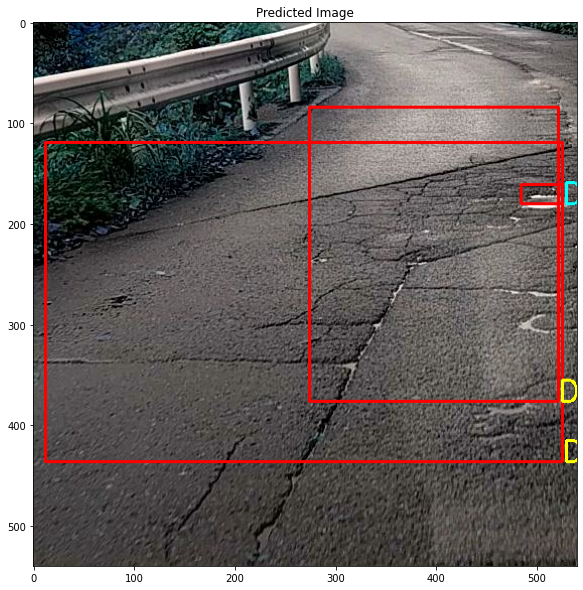

In [8]:
PATH='Japan_000288.jpg'
predict(PATH)